## Managing Imports

In [ ]:
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import RobustScaler


## Initialising Dataset + Extra Processing 
Nothing too difficult here. Just for notice, scope tuning (will store scope - 1 hours of data for prediction)

In [2]:
scope = 49

Working with data. You can see all featue selection here!

In [3]:
# Load data
data = pd.read_csv("Preprocessed_Solar_Power_Data_v3.csv")


# drop NA rows
data = data.dropna()

lagged_cols_demand = {f"lag_{lag}": data["TOTALDEMAND"].shift(lag) for lag in range(1, scope)}
lagged_df_demand = pd.DataFrame(lagged_cols_demand, index=data.index)
data_demand = pd.concat([data, lagged_df_demand], axis=1).dropna()

X1 = data_demand[[
    "T2M", "T2MDEW", "T2MWET", "RH2M", "PS", "WS2M",
    "Basel Wind Gust", "Basel Wind Direction [10 m]",
    "Basel Precipitation Total", "Basel Wind Speed [10 m]", "Basel Cloud Cover Total",
    "HOUR_SIN", "HOUR_COS", "WEEKDAY_SIN", "WEEKDAY_COS",
] + [f"lag_{i}" for i in range(1, scope)] + [
    "WEEKDAY_0", "WEEKDAY_1", "WEEKDAY_2", "WEEKDAY_3", "WEEKDAY_4", "WEEKDAY_5", "WEEKDAY_6"
]]

y1 = data_demand["TOTALDEMAND"]

lagged_cols_irr = {f"lag_{lag}": data["ALLSKY_SFC_SW_DWN"].shift(lag) for lag in range(1, scope)}
lagged_df_irr = pd.DataFrame(lagged_cols_irr, index=data.index)
data_irr = pd.concat([data, lagged_df_irr], axis=1).dropna()

X2 = data_irr[[
    "T2M", "T2MDEW", "T2MWET", "RH2M", "PS", "WS2M",
    "Basel Wind Gust", "Basel Wind Direction [10 m]",
    "Basel Precipitation Total", "Basel Wind Speed [10 m]", "Basel Cloud Cover Total",
    "HOUR_SIN", "HOUR_COS", "WEEKDAY_SIN", "WEEKDAY_COS",
] + [f"lag_{i}" for i in range(1, scope)] + [
    "WEEKDAY_0", "WEEKDAY_1", "WEEKDAY_2", "WEEKDAY_3", "WEEKDAY_4", "WEEKDAY_5", "WEEKDAY_6"
]]

y2 = data_irr["ALLSKY_SFC_SW_DWN"]


## Run this before any test!
Also, I will give a quick overview of all of the relevant graphs in case!

In [4]:
def metrics(y, X, pipeline):
    tscv = TimeSeriesSplit(n_splits=5)

    # Reset inside the function
    train_metrics = {'MSE': [], 'MAE': [], 'RMSE': [], 'R2': []}
    test_metrics  = {'MSE': [], 'MAE': [], 'RMSE': [], 'R2': []}
    
    for fold, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        pipeline.fit(X_train, y_train)

        y_train_pred = pipeline.predict(X_train)
        y_test_pred  = pipeline.predict(X_test)

        mse_train = mean_squared_error(y_train, y_train_pred)
        mae_train = mean_absolute_error(y_train, y_train_pred)
        rmse_train = mse_train ** 0.5
        r2_train = r2_score(y_train, y_train_pred)

        mse_test = mean_squared_error(y_test, y_test_pred)
        mae_test = mean_absolute_error(y_test, y_test_pred)
        rmse_test = mse_test ** 0.5
        r2_test = r2_score(y_test, y_test_pred)

        train_metrics['MSE'].append(mse_train)
        train_metrics['MAE'].append(mae_train)
        train_metrics['RMSE'].append(rmse_train)
        train_metrics['R2'].append(r2_train)

        test_metrics['MSE'].append(mse_test)
        test_metrics['MAE'].append(mae_test)
        test_metrics['RMSE'].append(rmse_test)
        test_metrics['R2'].append(r2_test)

        print(f"Fold {fold+1}:")
        print(f"Train -> MSE: {mse_train:.2f}, MAE: {mae_train:.2f}, RMSE: {rmse_train:.2f}, R2: {r2_train:.2f}")
        print(f"Test  -> MSE: {mse_test:.2f}, MAE: {mae_test:.2f}, RMSE: {rmse_test:.2f}, R2: {r2_test:.2f}")
        print("______________")

    print("Average Training Metrics:")
    print({k: sum(v)/len(v) for k, v in train_metrics.items()})
    print("Average Testing Metrics:")
    print({k: sum(v)/len(v) for k, v in test_metrics.items()})

    residuals = y_test - y_test_pred

    spearman = stats.spearmanr(y_test, y_test_pred).correlation
    kendall = stats.kendalltau(y_test, y_test_pred).correlation
    print(f"Spearman ρ: {spearman:.3f}, Kendall τ: {kendall:.3f}")

    y_shuffled = y_test.sample(frac=1.0, random_state=42)
    r2_shuffled = r2_score(y_shuffled, y_test_pred)
    print(f"R² shuffled: {r2_shuffled:.3f}") 
    
    # Residual vs Predicted
    sns.scatterplot(x=y_test_pred, y=residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title("Residuals vs Predicted")
    plt.show()

    # Distribution of residuals
    sns.histplot(residuals, kde=True)
    plt.axvline(0, color='red', linestyle='--')
    plt.title("Residual Distribution")
    plt.show()

    # Q-Q Plot (normality check)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.show()

    # Select only numeric columns
    numeric_X = X.select_dtypes(include=['float64', 'int64'])

    # Correlation between each feature and the true target
    corr_with_target = numeric_X.corrwith(y).sort_values(ascending=False)
    plt.figure(figsize=(6,8))
    sns.barplot(x=corr_with_target, y=corr_with_target.index, orient='h')
    plt.title("Feature Correlation with Target (y)")
    plt.xlabel("Correlation Coefficient (Pearson)")
    plt.show()

    plt.figure(figsize=(12,6))
    plt.plot(y_test.values, label="Actual")
    plt.plot(y_test_pred, label="Predicted", alpha=0.7)
    plt.legend()
    plt.title("Actual vs Predicted Demand (Last Fold)")
    plt.show()

    corrs = X[[col for col in X.columns if col.startswith("lag_")]].corrwith(y)
    plt.plot(range(1, len(corrs) + 1), corrs)
    plt.title("Lag Correlation with Target")
    plt.show()    
    
    plt.plot(residuals)
    plt.title("Residuals over Time")
    plt.show()




## Initialising MLP Pipeline
Run this code to get MLP training (needs to run once to initialise everything)

In [5]:
Solar_Pipeline = None
Demand_Pipeline = None
test = None

def setMLP():
    global Solar_Pipeline, Demand_Pipeline, test

    Solar_Regressor = MLPRegressor(
        hidden_layer_sizes=(50,50),
        max_iter=4000,
        activation='relu',
        solver='adam',
        learning_rate_init=0.006247564316322379,
        learning_rate='adaptive',
        alpha=0.0007174815096277166,
        early_stopping=True,
        random_state=42
    )

    # Pipeline
    Solar_Pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('mlp', Solar_Regressor)
    ])

    Demand_Regressor = MLPRegressor(
        hidden_layer_sizes=(20,20,20,15),
        max_iter=4000,
        activation='relu',        
        solver='adam',
        learning_rate_init=0.004253303307632643, 
        learning_rate='adaptive',
        alpha=00.0006208342600258237,
        early_stopping=True,
        random_state=42
    )

    # Pipeline
    Demand_Pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('mlp', Demand_Regressor)
    ])

    return Solar_Pipeline, Demand_Pipeline, "MLP"

def setWNN():
    global Solar_Pipeline, test

    n_neighbors = 10
    weights = "distance"
    algorithm = "auto"
    metric = "minkowski"
    p = 2
    leaf_size = 30
    n_jobs = None
    metric_params = None

    # Use the same feature selection and PCA settings from your earlier code
    k_select = 50           # adjust if you use different feature count logic
    pca_components = 20     # adjust if needed
    random_state = 42

    Solar_Pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler()),
        ("select", SelectKBest(score_func=mutual_info_regression, k=k_select)),
        ("pca", PCA(n_components=pca_components, svd_solver="auto", random_state=random_state)),
        ("knn", KNeighborsRegressor(
            n_neighbors=n_neighbors,
            weights=weights,
            algorithm=algorithm,
            leaf_size=leaf_size,
            metric=metric,
            metric_params=metric_params,
            n_jobs=n_jobs,
            p=p
        )),
    ])

    return Solar_Pipeline, Solar_Pipeline, "WNN"

def setModel(model):
    global Solar_Pipeline, Demand_Pipeline, test
    if model == "WNN":
        return setWNN()
    elif model == "MLP":
        return setMLP()
    else:
        print("No model assigned.")

## Setting the Solar/Demand Pipelines
Run and modify model based on the model you want to obtain data for.

Training MLP Irradiance ML Model. Please wait...
Fold 1:
Train -> MSE: 29335.61, MAE: 121.97, RMSE: 171.28, R2: 0.98
Test  -> MSE: 51795.60, MAE: 175.07, RMSE: 227.59, R2: 0.97
______________
Fold 2:
Train -> MSE: 22237.68, MAE: 102.36, RMSE: 149.12, R2: 0.99
Test  -> MSE: 38657.63, MAE: 150.51, RMSE: 196.62, R2: 0.98
______________
Fold 3:
Train -> MSE: 21291.00, MAE: 99.77, RMSE: 145.91, R2: 0.99
Test  -> MSE: 25377.30, MAE: 117.19, RMSE: 159.30, R2: 0.98
______________
Fold 4:
Train -> MSE: 16740.12, MAE: 88.34, RMSE: 129.38, R2: 0.99
Test  -> MSE: 23694.60, MAE: 114.60, RMSE: 153.93, R2: 0.99
______________
Fold 5:
Train -> MSE: 20492.12, MAE: 96.77, RMSE: 143.15, R2: 0.99
Test  -> MSE: 32036.80, MAE: 129.69, RMSE: 178.99, R2: 0.98
______________
Average Training Metrics:
{'MSE': 22019.30366964957, 'MAE': 101.84279737788044, 'RMSE': 147.7696146882426, 'R2': 0.9854136153409737}
Average Testing Metrics:
{'MSE': 34312.38708644163, 'MAE': 137.41320407333285, 'RMSE': 183.28464635217276,

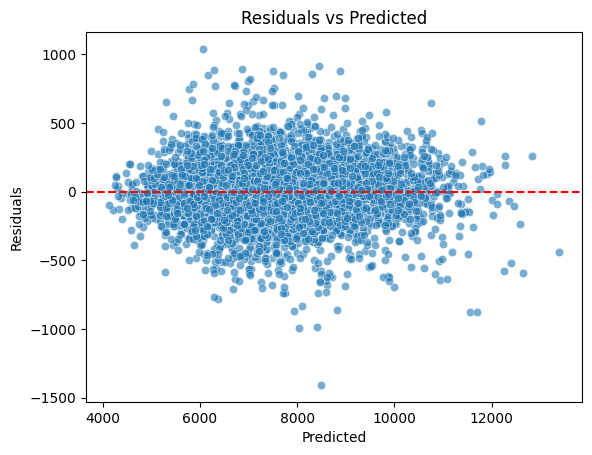

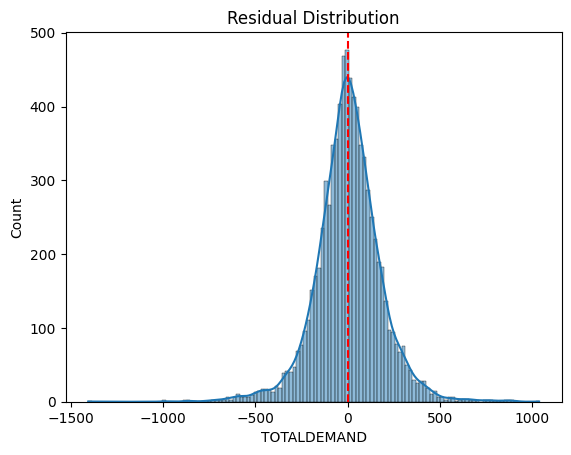

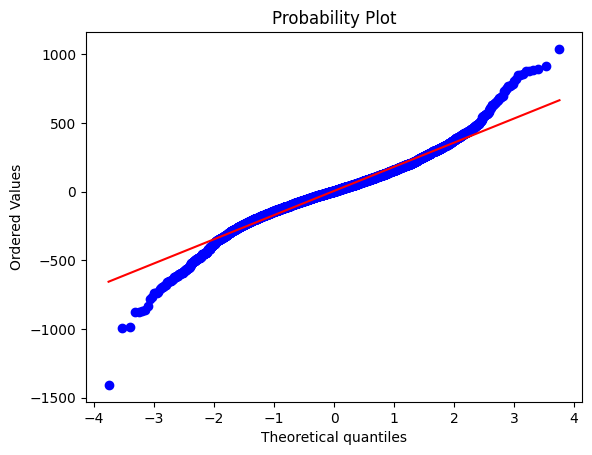

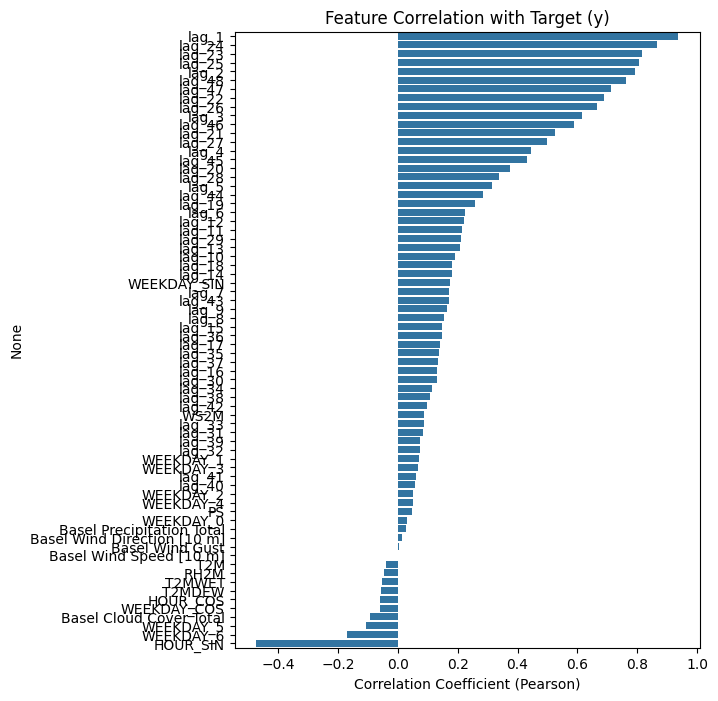

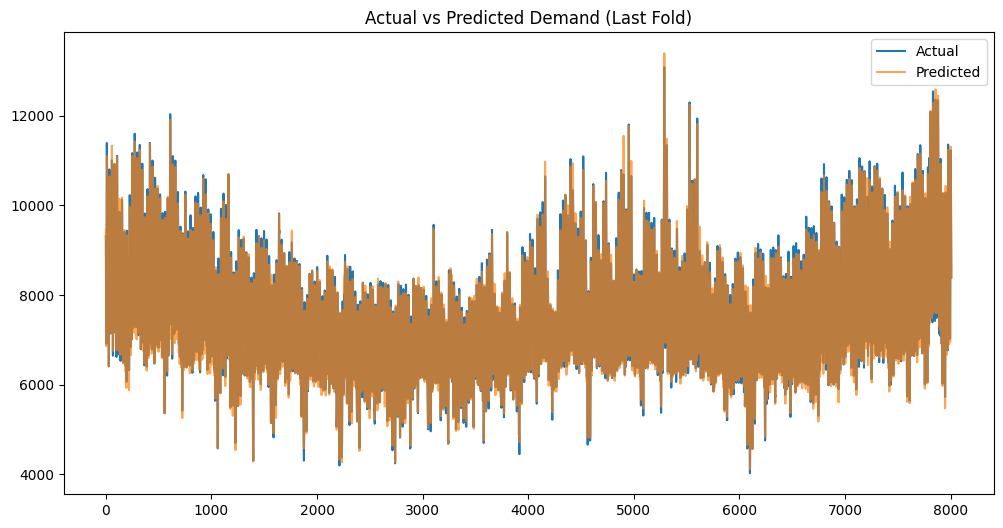

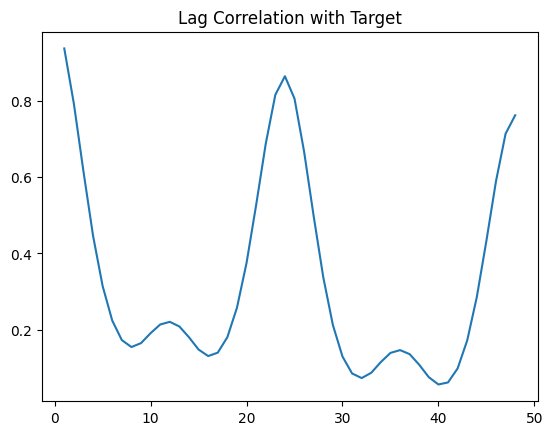

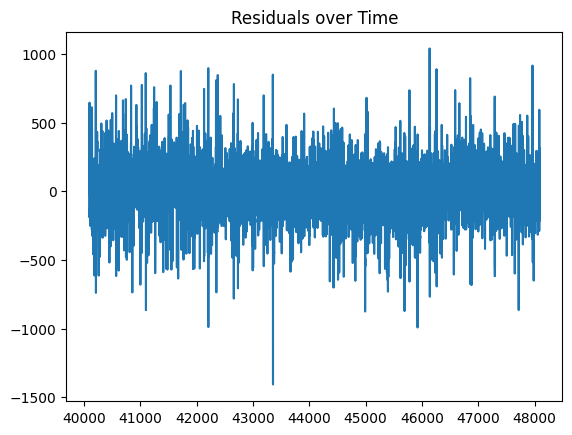

Training MLP Demand ML Model. Please wait...
Fold 1:
Train -> MSE: 820.89, MAE: 13.92, RMSE: 28.65, R2: 0.99
Test  -> MSE: 1081.47, MAE: 15.81, RMSE: 32.89, R2: 0.99
______________
Fold 2:
Train -> MSE: 855.83, MAE: 13.63, RMSE: 29.25, R2: 0.99
Test  -> MSE: 1152.21, MAE: 15.93, RMSE: 33.94, R2: 0.98
______________
Fold 3:
Train -> MSE: 888.86, MAE: 13.34, RMSE: 29.81, R2: 0.99
Test  -> MSE: 1102.97, MAE: 14.82, RMSE: 33.21, R2: 0.98
______________
Fold 4:
Train -> MSE: 906.94, MAE: 13.67, RMSE: 30.12, R2: 0.99
Test  -> MSE: 1075.77, MAE: 15.10, RMSE: 32.80, R2: 0.98
______________
Fold 5:
Train -> MSE: 919.53, MAE: 13.43, RMSE: 30.32, R2: 0.99
Test  -> MSE: 947.58, MAE: 14.02, RMSE: 30.78, R2: 0.99
______________
Average Training Metrics:
{'MSE': 878.4082892223583, 'MAE': 13.598665799586456, 'RMSE': 29.631712366505848, 'R2': 0.9882086587390109}
Average Testing Metrics:
{'MSE': 1072.000098031565, 'MAE': 15.135591469540469, 'RMSE': 32.724530040809334, 'R2': 0.9857495687418828}
Spearman 

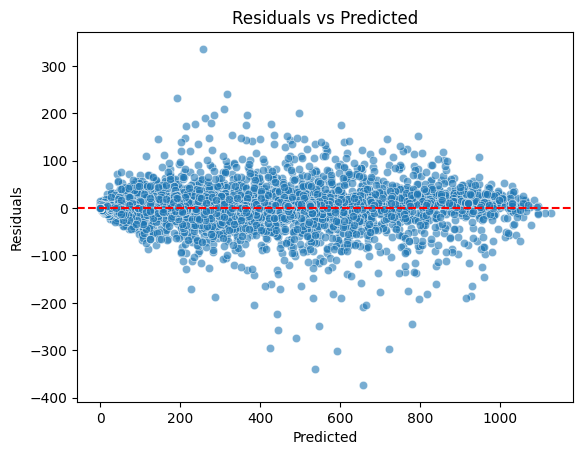

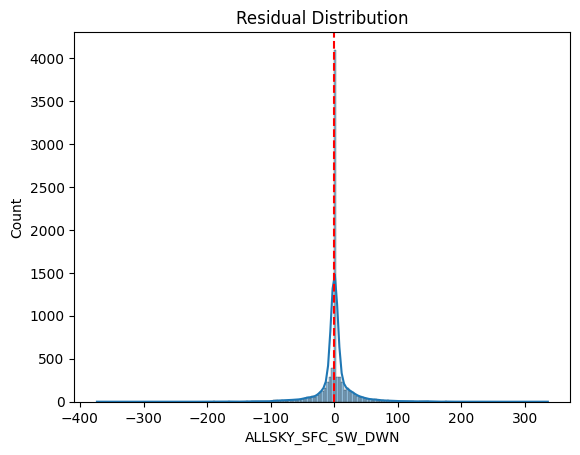

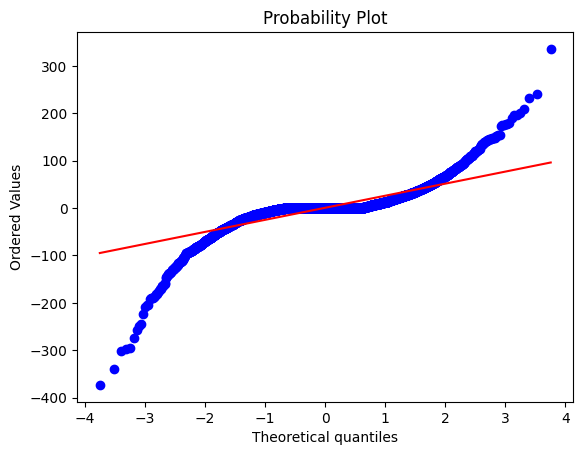

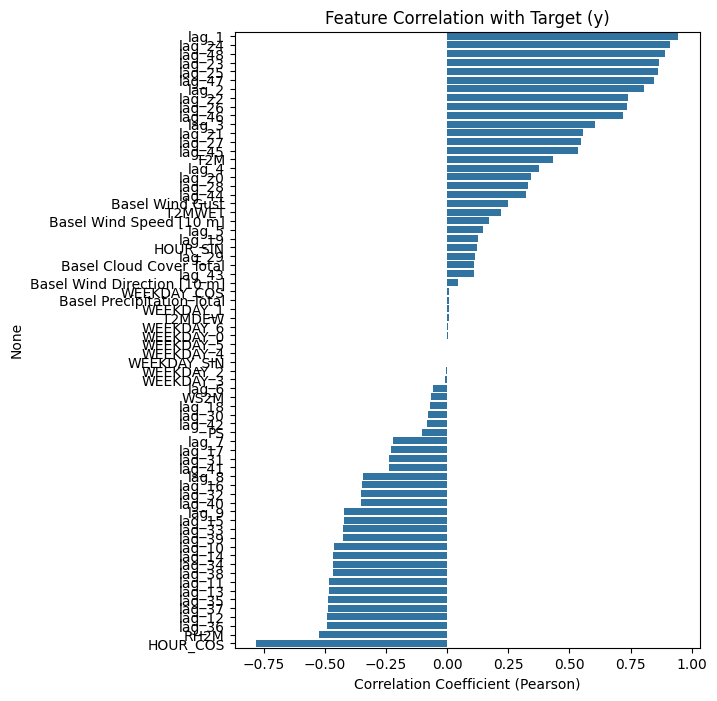

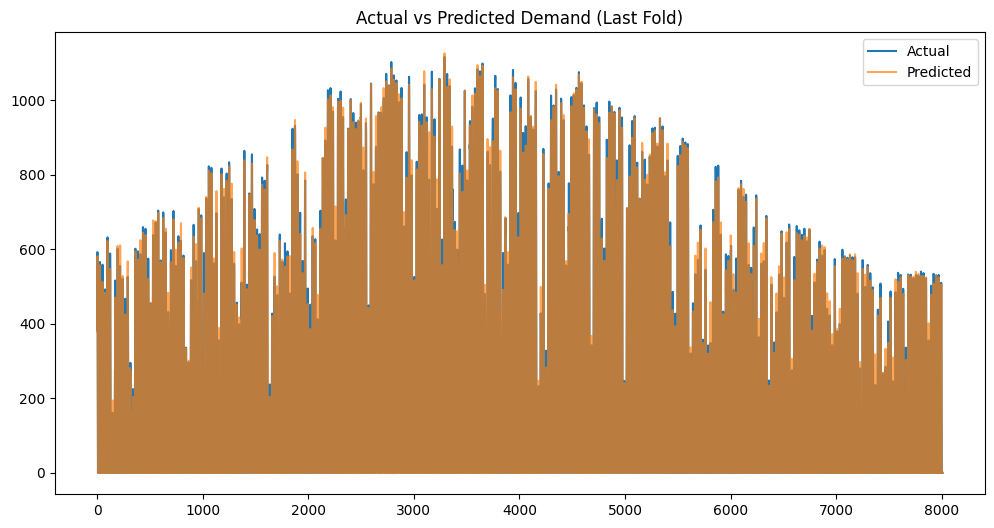

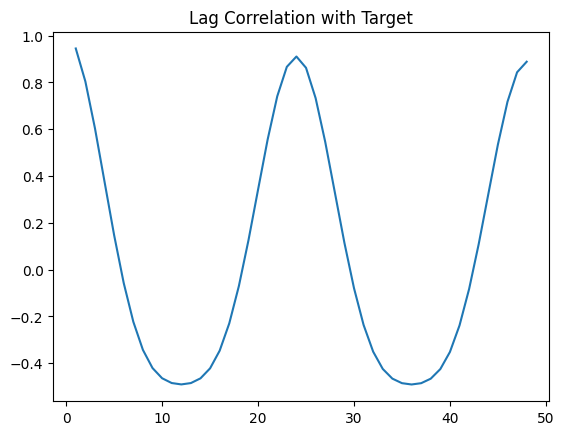

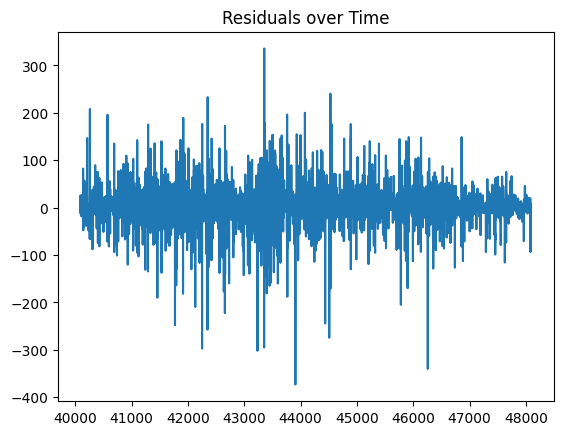

In [6]:
# Choose between "WNN", "RF", "MLP"
model = "MLP"
Solar_Pipeline, Demand_Pipeline, test = setModel(model)
print(f"Training {test} Irradiance ML Model. Please wait...")
metrics(y1, X1, Solar_Pipeline)
print(f"Training {test} Demand ML Model. Please wait...")
metrics(y2, X2, Demand_Pipeline)


